In [1]:
import numpy as np
from typing import Tuple
from collections import defaultdict
import matplotlib.pyplot as plt
from tqdm import tqdm
import mplcyberpunk


plt.style.use('cyberpunk')

In [2]:
class TicTacToe:
    def __init__(self):
        self.board = np.zeros((3, 3))
        self.board_prev = (0, 0)
    
    def mark(self, position: Tuple[int, int], player: int) -> None:
        """marks the board at given position for given player

        Args:
            position (Tuple[int, int]): position on the board. Tuple[0-2, 0-2]
            player (int): who is the player 1 (player), 2 (opponent)
        """
        # if not self.board[position]:
        self.board_prev = position
        self.board[position] = player
    
    def undo(self):
        self.board[self.board_prev] = 0
    
    def return_available(self) -> np.ndarray:
        """
        Returns the array of available moves

        Returns:
            np.ndarray: array of available moves
        """
        temp = np.where(self.board==0)
        return np.c_[temp[0], temp[1]]

    def mark_random(self, player):
        available_moves = self.return_available()
        idx = np.random.choice(available_moves.shape[0], 1)[0]
        move = tuple(available_moves[idx])
        self.mark(move, player=player)
    
    def mark_safe(self, player):
        available_moves = self.return_available()
        for move in available_moves:
            self.mark(tuple(move), player)
            if self.check_win() == player:
                return
            self.undo()
        player ^= 3
        for move in available_moves:
            self.mark(tuple(move), player)
            if self.check_win() == player:
                self.undo()
                player ^= 3
                self.mark(tuple(move), player)
                return
            self.undo()
        player ^= 3
        self.mark_random(player=player)
        
    def check_win(self):
        for j in range(1,3):
            if (self.board==j).all(axis=1).any() :
                return j
            if (self.board==j).all(axis=0).any():
                return j
            if (np.diag(self.board)==j).all():
                return j
            if (np.diag(self.board[::-1])==j).all():
                return j
        return 0
    
    def check_end(self):
        return self.board.all() or self.check_win()

In [3]:
class Player:
    def __init__(self) -> None:
        self.value = [None, defaultdict(float), defaultdict(float)]
        self.n_visits = defaultdict(int)
    
    def reset(self):
        self.value = [None, defaultdict(float), defaultdict(float)]
        self.n_visits = defaultdict(int)

    
    def choose(self, board, player):
        possible_actions = board.return_available()
        scores = np.zeros(possible_actions.shape[0])
        for idx, action in enumerate(possible_actions):
            board.mark(tuple(action), player)
            state = board.board.data.tobytes()
            board.undo()
            scores[idx] = self.value[player][state]
        return tuple(possible_actions[np.argmax(scores)])

    def selection(self, player: int, board: TicTacToe, path: list):
        possible_actions = board.return_available()
        
        # if terminal state has been reached
        if possible_actions.size == 0 or board.check_win():
            winner = board.check_win()
            if player == winner:
                reward = -1
            if winner == 0:
                reward = 0
            else:
                reward = 1
            player ^= 3
            self.backprop(path, reward, player)
            return

        uct_scores = np.zeros(possible_actions.shape[0])
        parent = board.board.data.tobytes()
        parent_visits = self.n_visits[parent]
        for idx, action in enumerate(possible_actions):
            board.mark(tuple(action), player)
            state = board.board.data.tobytes()
            board.undo()
            uct_scores[idx] = self.value[player][state]
            state_visits = self.n_visits[state]
            if state_visits == 0:
                path.append(state)
                board.mark(tuple(action), player)
                player ^= 3
                reward = self.rollout(player, board)
                player ^= 3
                self.backprop(path, reward, player)
                return

            uct_scores[idx] += 1*np.sqrt(parent_visits/state_visits)

        best_action_idx = np.argmax(uct_scores)
        best_action = possible_actions[best_action_idx]
        board.mark(tuple(best_action), player)
        path.append(board.board.data.tobytes())
        player ^= 3
        self.selection(player, board, path)

    
    def rollout(self, player: int, board: TicTacToe) -> float:
        op = player
        while not board.check_end():
            board.mark_random(player = player)
            player ^= 3
        winner = board.check_win()
        if winner == 0:
            return 0
        if winner == op:
            return -1
        else:
            return 1

    def backprop(self, path: list, reward: float, player: int):
        for state in path[::-1]:
            self.n_visits[state] += 1
            self.value[player][state] += (reward-self.value[player][state])/self.n_visits[state]
            reward *= -0.95
            player ^= 3
        return

        

# Part-b

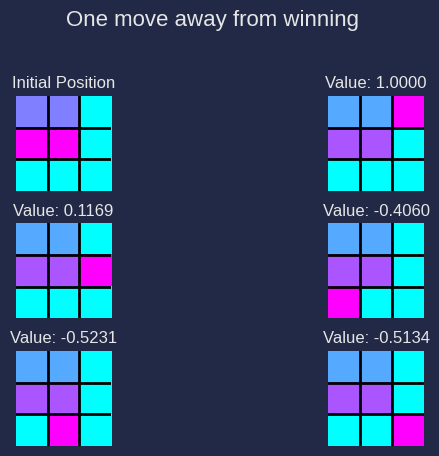

In [20]:
board = TicTacToe()
board.board = np.array([[1, 1, 0],[2, 2, 0], [0, 0, 0]])
state = board.board.data.tobytes()
board_copy = np.array(board.board)
mcts = Player()

for i in range(1000):
    mcts.selection(1, board, [state])
    board.board = np.array(board_copy)


moves = board.return_available()

fig, ax = plt.subplots(3, 2, constrained_layout=True)
fig.tight_layout()
ax[0][0].imshow(board.board)
ax[0][0].set_title("Initial Position")
ax[0][0].set_xticks(np.array([0.5, 1.5]))
ax[0][0].set_yticks(np.array([0.5, 1.5]))
ax[0][0].grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
ax[0][0].set_xticklabels([])
ax[0][0].set_yticklabels([])
x, y = 0, 0
for idx, move in enumerate(moves):
    board.board = np.array(board_copy)
    y += 1
    if y == 2:
        y = 0
        x += 1
    board.mark(tuple(move), 1)
    val = mcts.value[1][board.board.data.tobytes()]
    board.mark(tuple(move), 3)
    ax[x][y].imshow(board.board)
    ax[x][y].set_title(f"Value: {val:.4f}")
    ax[x][y].set_xticks(np.array([0.5, 1.5]))
    ax[x][y].set_yticks(np.array([0.5, 1.5]))
    ax[x][y].grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
    ax[x][y].set_xticklabels([])
    ax[x][y].set_yticklabels([])
fig.suptitle('One move away from winning', fontsize=16)
plt.subplots_adjust(top=0.8)
plt.show()



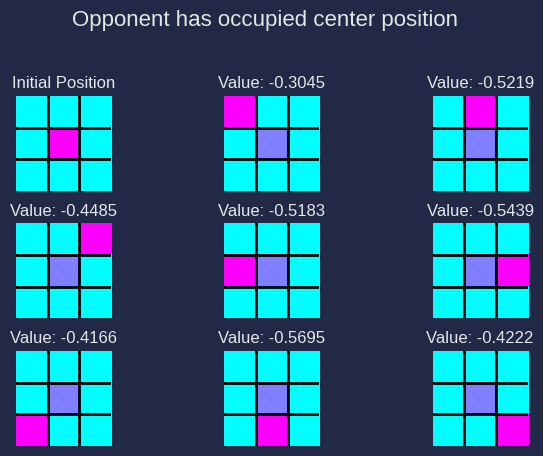

In [19]:
board = TicTacToe()
board.board = np.array([[0, 0, 0],[0, 1, 0], [0, 0, 0]])
state = board.board.data.tobytes()
board_copy = np.array(board.board)
mcts = Player()

for i in range(1000):
    mcts.selection(2, board, [state])
    board.board = np.array(board_copy)


moves = board.return_available()

fig, ax = plt.subplots(3, 3, constrained_layout=True)
fig.tight_layout()
ax[0][0].imshow(board.board)
ax[0][0].set_title("Initial Position")
ax[0][0].set_xticks(np.array([0.5, 1.5]))
ax[0][0].set_yticks(np.array([0.5, 1.5]))
ax[0][0].grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
ax[0][0].set_xticklabels([])
ax[0][0].set_yticklabels([])
x, y = 0, 0
for idx, move in enumerate(moves):
    board.board = np.array(board_copy)
    y += 1
    if y == 3:
        y = 0
        x += 1
    board.mark(tuple(move), 2)
    val = mcts.value[2][board.board.data.tobytes()]
    ax[x][y].imshow(board.board)
    ax[x][y].set_title(f"Value: {val:.4f}")
    ax[x][y].set_xticks(np.array([0.5, 1.5]))
    ax[x][y].set_yticks(np.array([0.5, 1.5]))
    ax[x][y].grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
    ax[x][y].set_xticklabels([])
    ax[x][y].set_yticklabels([])
fig.suptitle('Opponent has occupied center position', fontsize=16)
plt.subplots_adjust(top=0.8)
plt.show()



# Part-c
Number of wins, losses against random and safe agent

In [5]:
def test_against_random(num_games, num_traverse_at_each_state):
    mcts = Player()
    wins, losses = 0, 0

    for _ in tqdm(range(num_games)):
        board = TicTacToe()
        random_marker = 2
        mcts_marker = 1
        if np.random.random() > 0.5:
            random_marker = 1
            mcts_marker = 2
            board.mark_random(random_marker)
        while not board.check_end():
            board_copy = np.array(board.board)
            state = board.board.data.tobytes()

            for _ in range(num_traverse_at_each_state):
                mcts.selection(mcts_marker, board, [state])
                board.board = np.array(board_copy)

            action = mcts.choose(board, mcts_marker)
            board.mark(action, player=mcts_marker)
            if board.check_end():
                break
            board.mark_random(player=random_marker)
        winner = board.check_win()
        wins += 1 if winner == mcts_marker else 0
        losses += 1 if winner == random_marker else 0


    print(f'wins against random: {wins}, losses against random: {losses}')

test_against_random(1000, 100)

100%|██████████| 1000/1000 [02:36<00:00,  6.41it/s]

wins against random: 909, losses against random: 8


In [6]:
def test_against_safe(num_games, num_traverse_at_each_state):
    mcts = Player()
    wins, losses = 0, 0

    for _ in tqdm(range(num_games)):
        board = TicTacToe()
        safe_marker = 2
        mcts_marker = 1
        if np.random.random() > 0.5:
            safe_marker = 1
            mcts_marker = 2
            board.mark_safe(safe_marker)
        while not board.check_end():
            mcts.reset()
            board_copy = np.array(board.board)
            state = board.board.data.tobytes()
            for _ in range(num_traverse_at_each_state):
                mcts.selection(mcts_marker, board, [state])
                board.board = np.array(board_copy)

            action = mcts.choose(board, mcts_marker)
            board.mark(action, player=mcts_marker)
            if board.check_end():
                break
            board.mark_safe(player=safe_marker)
        winner = board.check_win()
        wins += 1 if winner == mcts_marker else 0
        losses += 1 if winner == safe_marker else 0

    print(f'wins against safe: {wins}, losses against safe: {losses}')

test_against_safe(1000, 1000)

100%|██████████| 1000/1000 [31:04<00:00,  1.86s/it]

wins against safe: 383, losses against safe: 11


# Part-d
Number of wins, losses of MCTS against itself.


In [7]:
def test_against_self(num_games, num_traverse_at_each_state):
    mcts = Player()
    wins, losses = 0, 0

    for _ in tqdm(range(num_games)):
        board = TicTacToe()

        while not board.check_end():
            board_copy = np.array(board.board)
            state = board_copy.data.tobytes()
            mcts.reset()
            for i in range(num_traverse_at_each_state):
                mcts.selection(1, board, [state])
                board.board = np.array(board_copy)

            action = mcts.choose(board, 1)
            board.mark(action, player=1)
            if board.check_end():
                break

            board_copy = np.array(board.board)
            state = board_copy.data.tobytes()
            mcts.reset()
            for _ in range(num_traverse_at_each_state):
                mcts.selection(2, board, [state])
                board.board = np.array(board_copy)

            action = mcts.choose(board, 2)
            board.mark(action, player=2)
        winner = board.check_win()
        wins += 1 if winner == 1 else 0
        losses += 1 if winner == 2 else 0

    print(f'wins against self: {wins}, losses against self: {losses}')

test_against_self(1000, 100)

100%|██████████| 1000/1000 [05:35<00:00,  2.98it/s]

wins against self: 403, losses against self: 34
